# Assignment 4

## Instructions
<ul>
    <li> Ensure that this assignment is your own work. PLagiarism will not be tolerated </li>
    <li> Ensure that all cells of this notebook run without error when run in order </li>
    <li> Follow the late day policy. Submit assignments on time </li>
    <li> Provide clear explanation for the algorithms you implement </li>
</ul>
Date released: 26/10/2020 

Due date: 01/11/2020 

Approximate time needed: 6-7 hours
    
## DLT and Epipolar Lines

The goal of this assignment is to aid your understanding of the Direct Linear Transform as well as Epipolar geometry.

For the first part of the assignment you will find correspondences between 2D-3D points and estimate the P Matrix. You will then be required to estimate Camera Parameters from this P matrix.

The second part of this assignment will require you to construct epipolar lines on two corresponding images.

---
## 4.1
### Generating Correspondences
The first step to perform DLT is to generate correspondences. The cell below opens a new window. Clicking anywhere on the image should give you the pixel location of the image. Once you're done clicking, close the image window. The cell after displays the points you have clicked.

In [1]:
%matplotlib tk
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import numpy as np


image_points = []
fig = plt.figure(figsize=(20,30))

img=mpimg.imread('Images/dlt1.jpeg')

def onclick(event):
    ix, iy = event.xdata, event.ydata
    # print(ix, iy)
    image_points.append([ix, iy])

cid = fig.canvas.mpl_connect('button_press_event', onclick)

imgplot = plt.imshow(img)
plt.show()

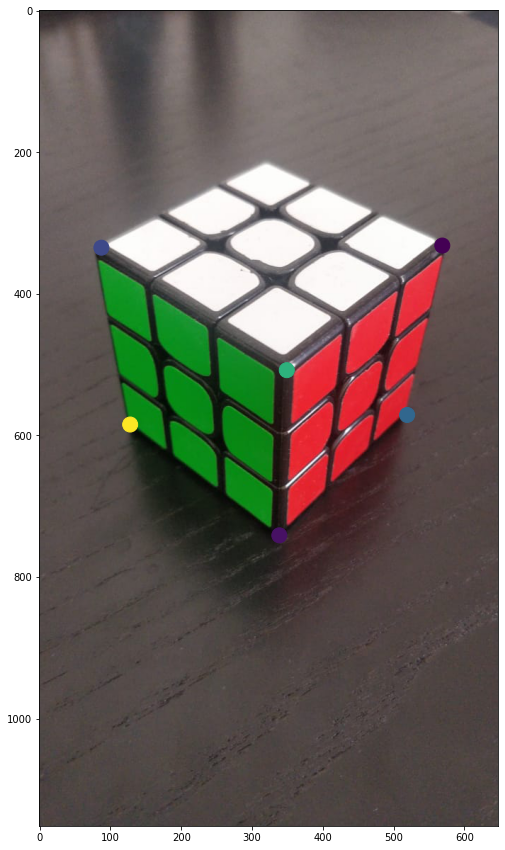

In [2]:
%matplotlib inline
N = len(image_points)
image_points = np.array(image_points)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(image_points[:,0], image_points[:,1], c=colors, s=area)
plt.show()

After generating pixel locations, you have to generate the corresponding world points. You have the freedom to chose which point you want as origin. You can consider each side as 4 units.

Ensure that the ordering of your points matches the ordering of image points. Keep track of the sequence of corners clicked.

In [3]:
#We'll rename image_points to x to match textbook convention
x = image_points
# X represents the 3D world points
X = []
#Add your points here
#Add them as 3D points only
# X.append([1,0,0])
X.append([0,0,0])
X.append([0,4,0])
X.append([4,4,0])
X.append([4,0,0])
X.append([4,0,-4])
X.append([4,4,-4])
X = np.array(X)

Now that we have the correspondences, we can estimate the P matrix. Implement the DLT function that returns the P matrix

Quick recap: x_i = P * X_i where (x_i, X_i) is the ith correspondence, and P is a 3x4 dimensional matrix. P is further decomposed as P = K * [ R | T].


In [4]:
#Helper functions
#appends a ones column to input
def hom_coords(x):
    n = x.shape[0]
    size = (n,1)
    ones = np.ones(size)
    x = np.concatenate(
        (x,ones),
        axis = 1)
    return x

x = hom_coords(x)
X = hom_coords(X)

#### Explanation

The **DLT algorithm** is used to estimate the P matrix.
We know that $P$ is a $3x4$ matrix, however, we need to solve only for 11 parameters since $x = PX$ is a homogenous equation. This means that we can divide $P$ by $P_{34}$ and thus solve only for 11 parameters.

Now, the equation that we have to solve is:
$$ x = PX, $$
where, \
$x$ denotes the image point (2D projection) \
$X$ denotes the same point in the world frame (3D) \
$P$ is the camera projection matrix

We can rewrite the equation as:
$$ x - PX = 0 $$
$$ 
\begin{bmatrix}
x_i \\
y_i \\
z_i
\end{bmatrix} - \begin{bmatrix}
P_{11} & P_{12} & P_{13} & P_{14} \\
P_{21} & P_{22} & P_{23} & P_{24} \\
P_{31} & P_{32} & P_{33} & P_{34}
\end{bmatrix} \begin{bmatrix}
X_i \\
Y_i \\
Z_i \\
\end{bmatrix} = 0
$$

On setting $z_i = 1$ by dividing throughout by $z_i$ and simplifying, we get,

$$
-X_iP_{11} - Y_iP_{12} - Z_iP_{13} -P_{14} + X_ix_iP_{31} + Y_ix_iP_{32} + Z_ix_iP_{33} + x_iP_{34} = 0
$$
$$
-X_iP_{21} - Y_iP_{22} - Z_iP_{23} -P_{24} + X_iy_iP_{31} + Y_iy_iP_{32} + Z_iy_iP_{33} + y_iP_{34} = 0
$$

This can be written as 
$$
A_{(2x12)}P_{(12x1)} = 0
$$
where, \
P is flattened into a $(12x1)$ vector, and \
$A$ contains the coefficients corresponding to each $P_{ij}$ based on the above equations.

We can see that we require the rank of $A$ to be atleast 11, and we get 2 rows in $A$ for each point. Thus we need $\ge 6$ points. We can then construct $A_{(2nx12)}$ as mentioned above.

To solve for P, we can now use SVD on $A$ to get $A = UDV^T$. This is because we know that we are solving for an overdetermined system and thus might not get a perfect P. Hence we minimize $||AP||^2$. This can be expanded as,
$P^TA^TAP$.

On applying SVD to A, we can rewrite $||AP||^2$ as,
$$||AP||^2 = P^T(VDU^T)(UDV^T)P$$
$$ = P^TVD^2V^TP$$

We can clearly see now, that to minimize this equation, we need to set P to be the vector in $V^T$ corresponding to the smallest eigenvalue in $D$. Hence, we get $P = V^T_{12}$.

In [5]:
#DLT function takes as input 
#the image points and world points
#return a 3x4 matrix
def DLT(x,X):
    """
    your code here
    """
    P = np.random.randn(3,4)
    l = len(X)
    A = [0 for i in range(2*l)]
    
    for i in range(l):
        Xi = X[i]
        xi = x[i]
        A[2*i] = [-Xi[0], -Xi[1], -Xi[2], -1,0,0,0,0, xi[0]*Xi[0], xi[0]*Xi[1], xi[0]*Xi[2], xi[0]]
        A[2*i +1] = [0,0,0,0, -Xi[0], -Xi[1], -Xi[2], -1, xi[1]*Xi[0], xi[1]*Xi[1], xi[1]*Xi[2], xi[1]]
    
    u,d,vh = np.linalg.svd(A)
    
    P = vh.T[:,-1].reshape((3,4))
    return P

P = DLT(x,X)

In [6]:
print("The Projection matrix estimated is:")
print(P)

The Projection matrix estimated is:
[[ 7.65280414e-02 -2.35525019e-02 -9.39773483e-02  2.09836031e-01]
 [ 4.24325382e-02 -1.28957469e-01  3.71020181e-02  9.59643696e-01]
 [-2.94273600e-05 -7.89211003e-05 -4.85006249e-05  1.64160258e-03]]


## Analysing P

The next part of this question is to analyse how good our estimate is. Report the reprojection error of your P matrix

In [7]:
#Get reprojected points
def get_points(P,X):
    points = P@X.T
    points = points / points[2]
    points = points.T[:,0:2]
    return points

#Get reprojection error
def get_err(x, X, P):
    points = get_points(P, X)
    """
    find the MSE between reprojected points
    and x
    """
    err = 0
    l = len(x)
    for i in range(l):
        err += np.sum((points[i] - x[i][:2])**2)
    #to err is to human
    return err/l

In [8]:
print("Reprojection Error is:", get_err(x, X, P))

Reprojection Error is: 0.0002720757306474359


Given the P matrix, we can estimate K, R and T. Write a function that returns K,R,T given P.
Note: 
P = K * [R | T] where K is a 3x3 matrix and [R | T], P are 3x4 matrices

In [9]:
def ret_RKT(P):
    """
    """
    H_inf = P[:3,:3]
    h = P[:,3]
    
    T = -np.linalg.inv(H_inf) @ h
    
    Rt, Kinv = np.linalg.qr(np.linalg.inv(H_inf))
    
    K = np.linalg.inv(Kinv)
    R = Rt.T
    
    return R, K, T 

R, K, T = ret_RKT(P)

#### Verifying the R, K, T Values

In [10]:
H_inf = K@R 
h = (-K@R@T).reshape(-1,1)
P_r = np.hstack([H_inf, h])

In [11]:
print("Is the reconstructed P matrix same as P?")
print(np.isclose(P, P_r).all())

Is the reconstructed P matrix same as P?
True


Reproject the world points with P matrix you have obtained via DLT:

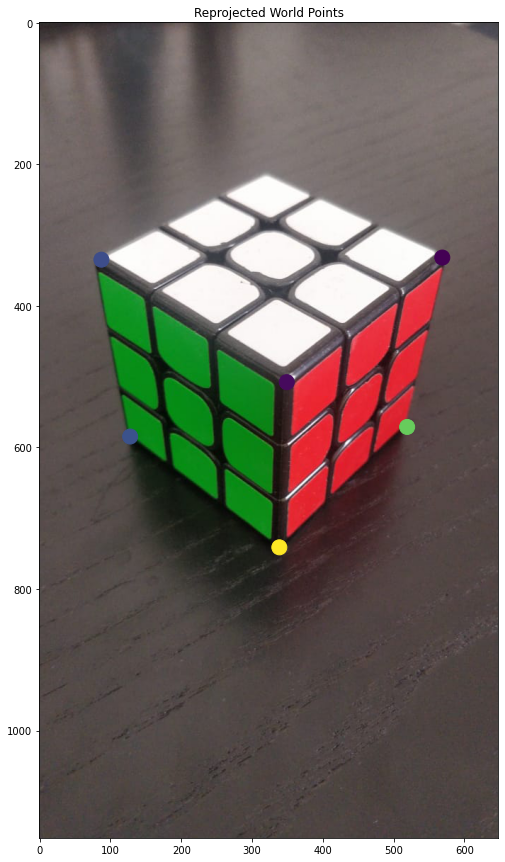

In [12]:
re_proj = get_points(P, X)
#code to plot these on the image
N = len(re_proj)
fig = plt.figure(figsize=(10,15))

img=mpimg.imread('Images/dlt1.jpeg')
imgplot = plt.imshow(img)

colors = np.random.rand(N)
area = (15 * np.ones(N))**2 

plt.scatter(re_proj[:,0], re_proj[:,1], c=colors, s=area)
plt.title("Reprojected World Points")
plt.show()

### Zhangs method

For this task, use the inbuilt Opencv function to estimate the K matrix of a camera. Use the checkerboard images 5456-5470 in images/zhangs folder for this task. Familiarize yourself with the different parameters for this method.

**Reference**: https://docs.opencv.org/3.4/dc/dbb/tutorial_py_calibration.html

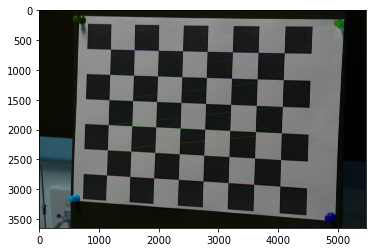

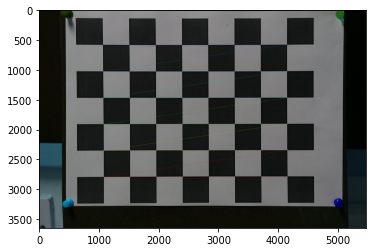

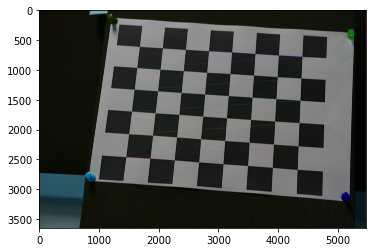

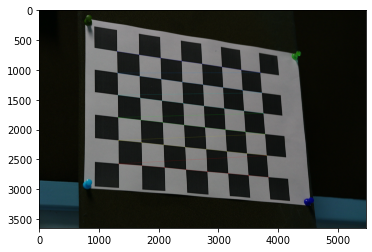

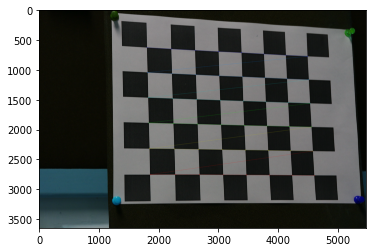

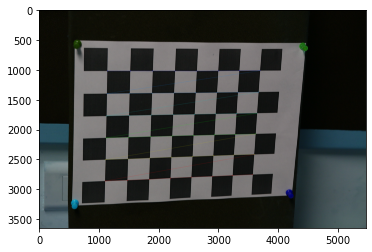

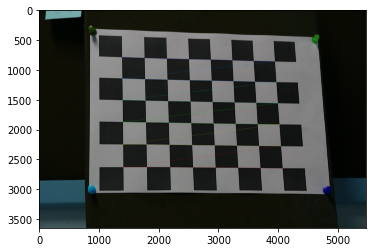

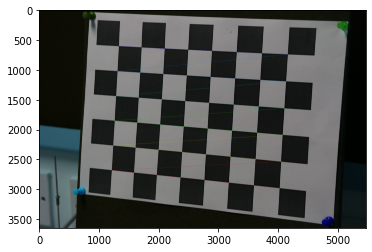

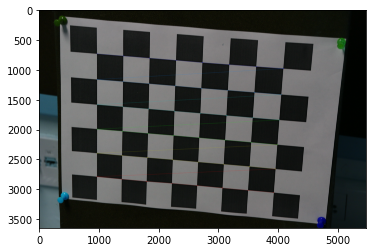

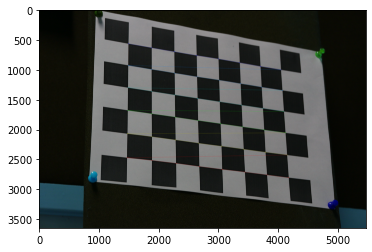

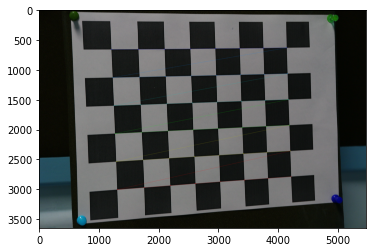

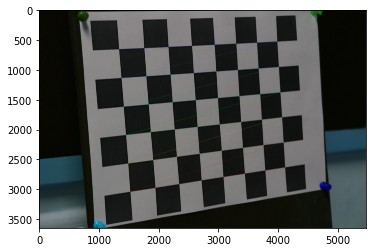

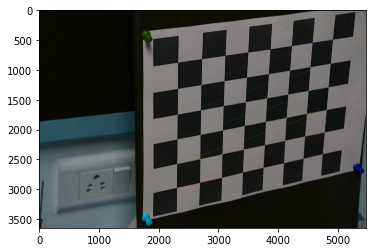

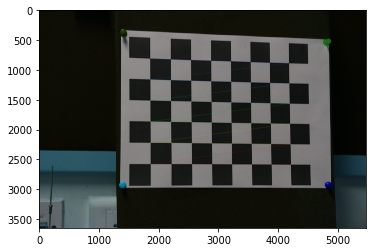

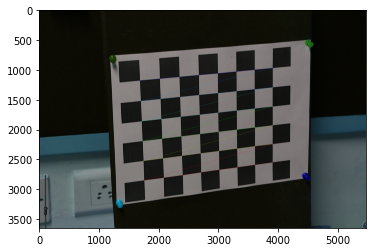

In [13]:
#Code for zhangs here
import cv2 as cv
import glob

# number of internal corners to be found
# a is no. of internal corners in each row
# b is no. of internal corners in each column
a = 8
b = 6

# setting the world coordinate locations for the corners
objp = np.zeros((a*b,3), np.float32)
objp[:,:2] = np.mgrid[0:a,0:b].T.reshape(-1,2)

# Corners in the world coordinates
objpoints = [] 

# 2D projection of the points (location on image)
imgpoints = []

# load the images
images = glob.glob('Images/Zhangs/*.JPG')

for fname in images:
    
    # load image and convert to grayscale
    img = cv.imread(fname)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    
    # Find the internal chess board corners
    ret, corners = cv.findChessboardCorners(gray, (a,b), None)
    
    # if corners were found
    if ret == True:
        
        # add the world frame coordinates of the internal corners
        objpoints.append(objp)
        
        # termination criteria for enhancing corners detected
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)
        
        # get internal corners of the chessboard in the image
        corners2 = cv.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)
        
        # visualising
        cv.drawChessboardCorners(img, (a,b), corners2, ret)
        plt.imshow(img)
        plt.show()


In [14]:
ret, mtx, dist, rvecs, tvecs = cv.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

In [15]:
mtx

array([[1.36415095e+04, 0.00000000e+00, 3.31635924e+03],
       [0.00000000e+00, 1.36632518e+04, 1.50037425e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

The above matrix is the calculated K.

---
## 4.2
### Epipolar lines
#### Task 1

For this task, you have been given two images of the same scene taken from different view-points. The fundamental matrix that encodes their relative geometry as well as a subset of corresponding points have been provided to you. The images are in q2 folder.

Recall that given a point in one image, it's corresponding location in the other image can be found to along a line viz. the epipolar line. The task given to you is to draw the epipolar lines in the second image for each given point in the first image. You have to repeat this for the other image as well. Draw epipolar lines on the first image for the corresponding points in the second image.

The convention used for F is $x'^{T}Fx$ where $x'$ is the location of the point in the second image.

In [16]:
data_file = "q2/data.txt"

with open(data_file, 'r') as f:
    A = f.readlines()
    
img_points1 = A[2:12]
img_points1 = [i.strip()[:-1] for i in img_points1]
img_points1[0] = img_points1[0][1:]
img_points2 = A[15:25]
img_points2 = [i.strip()[:-1] for i in img_points2]
img_points2[0] = img_points2[0][1:]

F_mat = A[28:31]
F_mat = [i.strip()[:-1] for i in F_mat]
F_mat[0] = F_mat[0][1:]

img_1 = []
img_2 = []
F_MAT = []

for i in img_points1:
    img_1.append(np.fromstring(i[1:-1], sep=' '))
    
for i in img_points2:
    img_2.append(np.fromstring(i[1:-1], sep=' '))
    
for i in F_mat:
    F_MAT.append(np.fromstring(i[1:-1], sep=' '))

img_1 = np.array(img_1)
img_2 = np.array(img_2)
F_mat = np.array(F_MAT)

Provide a clear explanation on your approach for both this task and the next:

In [17]:
#Write code to plot epipolar lines on the images
img_1_pt = hom_coords(img_1)
img_2_pt = hom_coords(img_2)

ep_line_1 = F_mat @ img_1_pt.T
ep_line_2 = F_mat.T @ img_2_pt.T

First, we convert our points to homogenous coordinates. 

We know that for a point $x$ in image 1, $Fx$ describes the epipolar line corresponding to this point in image 2. Here, ```ep_line_1``` is the epipolar line derived from points in image 1. For the epipolar lines corresponding to image 2, the line is described by $F^Tx'$ where $x'$ is a point in image 2.

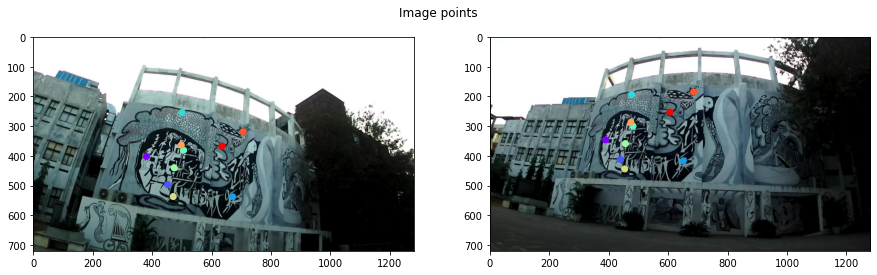

In [18]:
img1 = mpimg.imread('q2/img1.jpg')
img2 = mpimg.imread('q2/img2.jpg')

colors = cm.rainbow(np.linspace(0, 1, len(img_1)))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Image points")

ax1.scatter(img_1[:,0], img_1[:,1], color=colors)
ax1.imshow(img1)
ax2.scatter(img_2[:,0], img_2[:,1], color=colors)
ax2.imshow(img2)
fig.set_figwidth(15)

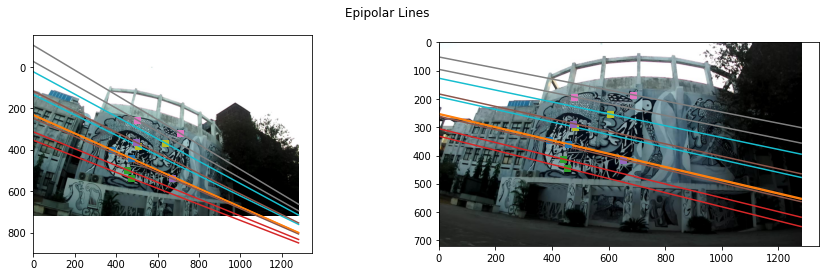

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle("Epipolar Lines")

for i in range(len(img_1_pt)):

    # ax + by + c = 0
    a1, b1, c1 = ep_line_1[:, i]
    a2, b2, c2 = ep_line_2[:, i]

    # Taking any two points on the image border
    x1, y1 = (0, img1.shape[0])
    x2, y2 = (img1.shape[1], 0)

    # y = -(c + ax)/b
    y1 = -(c1 + a1*x1)/b1
    y2 = -(c1 + a1*x2)/b1

    ax2.plot(img_2[i][0], img_2[i][1], 's')
    ax2.plot([x1, x2], [y1, y2])
    
    # y = -(c + ax)/b
    y1 = -(c2 + a2*x1)/b2
    y2 = -(c2 + a2*x2)/b2
    
    ax1.plot(img_1[i][0], img_1[i][1], 's')
    ax1.plot([x1, x2], [y1, y2])

ax1.imshow(img1)
ax2.imshow(img2)
fig.set_figwidth(15)
plt.show()

Once we have obtained the epipole line equations, we can choose any two points on the image to draw the line. For convenience, we take points on the $X$ and $Y$ axis. By substiting the $x$ coordinates, we compute $y$ as $\frac{-(c + ax)}{b}$ for these two points. Then, drawing the epipolar line is as  simple as joining these two points.

Note that we repeat the above procedure for each of the points in both images, to draw all the corresponding epipolar lines.

#### Task 2
Report the location of the epipoles.

In [20]:
import scipy
from scipy import linalg, matrix

# Referred to https://stackoverflow.com/questions/5889142/python-numpy-scipy-finding-the-null-space-of-a-matrix
def null(A, eps=1e-12):
    u, s, vh = scipy.linalg.svd(A)
    null_mask = (s <= eps)
    null_space = np.compress(null_mask, vh, axis=0)
    return np.transpose(null_space)

The above function returns the null space of the matrix. This is done by picking the eigenvectors with singular value $0$ (which can be found using SVD). 

In [21]:
ep_2 = null(F_mat)
ep_2 /= ep_2[2][0]

ep_1 = null(F_mat.T)
ep_1 /= ep_1[2][0]

print("Epipole for image 1:", ep_1[:2,0])
print("Epipole for image 2:", ep_2[:2,0])

Epipole for image 1: [-5131.90963838  -948.85463066]
Epipole for image 2: [2159.16628306 1189.26810028]


Epipoles satisfy the equation $Fx=0$ (image 1) and $F^Tx'=0$ (image 2). Hence, the solutions $x$ and $x'$ belong to the nullspace of $F$ and $F^T$ respectively. The null function defined earlier helps us calculate the nullspace of the input matrix, giving us our epipoles in this case. Once we have obtained our points, we normalize it to get a 2D cartesian point.